In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    Conv2DTranspose,
    Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import time

from skimage.transform import rescale, resize


import h5py
import numpy as np
from racts_utils import load_sim_data 


2023-04-30 17:46:12.531413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 17:46:16.840775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-30 17:46:16.840976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-30 17:46:16.841005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

# Declare model

In [2]:
class ChangeSamplingRate(tf.keras.layers.Layer):
    def __init__(self, sr=0.1):
        super(ChangeSamplingRate, self).__init__()
        self.sr = sr
    
        indices = np.arange(0, 512, 1/self.sr).astype(int)
        print("effective sr: {:.2f}".format(len(indices)/512))  
        
    def call(self, x):
        sampled_sinogram = self.sample_sino(x)
        return sampled_sinogram

    def sample_sino(self, sinogram):

        # get number of columns in sinogram (equivalent to number of samples taken in scan)
        n_s = sinogram.shape[2] # 2 is the right dimension for BATCHED INPUT; otherwise 1

        # for given sampling rate, get columns that will not be sampled
        indices = np.arange(0, n_s, 1/self.sr).astype(int)
        theta_inds = np.arange(0, n_s)
        zero_inds = list(set(theta_inds) - set(indices)) # indices to be set to 0
        
        # set non-sampled columns to 0
        mask = [tf.one_hot(col_num*tf.ones((sinogram.shape[1], ), dtype=tf.int32), sinogram.shape[2])
                for col_num in zero_inds]
        mask = tf.reduce_sum(mask, axis=0)
        mask = tf.cast(tf.logical_not(tf.cast(mask, tf.bool)), tf.float32)
        mask = tf.expand_dims(mask, 0)
        mask = tf.expand_dims(mask, -1)
        result = sinogram * mask

        return result

def unet_model(input_shape=(512, 512, 1), base_filter=64, kernel_size=3,strides=(1, 1), sr=0.1):
    """
    sr : sampling_rate
    """
    
    inputs = Input(input_shape)

    #physical layer
    x = ChangeSamplingRate(sr)(inputs) # sr --> percentage sampled
    
    # down
    con1 = Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(x)
    con1 = Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(con1)
    x = MaxPooling2D(pool_size=(2, 2))(con1)
    con2 = Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(x)
    con2 = Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(con2)
    x = MaxPooling2D(pool_size=(2, 2))(con2)
    con3 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(x)
    con3 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(con3)
    x = MaxPooling2D(pool_size=(2, 2))(con3)
    con4 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(x)
    con4 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(con4)
    x = MaxPooling2D(pool_size=(2, 2))(con4)
    
    con5 =  Conv2D(base_filter*16, kernel_size, strides, padding='same', activation="relu")(x)
    con5 =  Conv2D(base_filter*16, kernel_size, strides, padding='same', activation="relu")(con5)


    # up
    up = Conv2DTranspose(base_filter*8, kernel_size, strides=(2,2), padding='same', activation='relu')(con5)
    merge1 = concatenate([up, con4], axis=-1)
    con6 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(merge1)
    con6 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(con6)
    up = Conv2DTranspose(base_filter*4, kernel_size, strides=(2,2), padding='same', activation='relu')(con6)
    merge2 = concatenate([up, con3], axis=-1)
    con7 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(merge2)
    con7 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(con7)
    up = Conv2DTranspose(base_filter*2, kernel_size, strides=(2,2), padding='same', activation='relu')(con7)
    merge3 = concatenate([up, con2], axis=-1)
    con8 =  Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(merge3)
    con8 =  Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(con8)
    up = Conv2DTranspose(base_filter, kernel_size, strides=(2,2), padding='same', activation='relu')(con8)
    merge4 = concatenate([up, con1], axis=-1)
    con9 =  Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(merge4)
    con9 =  Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(con9)
    out = Conv2D(1, kernel_size=(1, 1), strides=(1,1), padding='same')(con9)
#     out = Conv2D(1, kernel_size=(1, 1), strides=(1,1), padding='same', activation="relu")(con9)


    return Model(inputs=inputs, outputs=out)

### METRICS

def normalize_image_batch(images):
    
    min_values = tf.reduce_min(images, axis=[1, 2], keepdims=True)
    max_values = tf.reduce_max(images, axis=[1, 2], keepdims=True)

    return (images - min_values) / (max_values - min_values)

def ssim(output, groundtruth):
    output = normalize_image_batch(output)
    groundtruth = normalize_image_batch(groundtruth)
    return tf.image.ssim(output, groundtruth, max_val=1.0, filter_size=4,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

def psnr(output, groundtruth):
    output = normalize_image_batch(output)
    groundtruth = normalize_image_batch(groundtruth)   
    return tf.image.psnr(output, groundtruth, max_val=1.0)


#### DATALOADER

# These were calculated from our training set
mean=56.23
variance=3902.5
sdev = np.sqrt(variance)
def get_ds(dset, version=2, n=1, ds_bsz = 1, mod='sino'):
    
    class generator:
        def __call__(self, index):
            img, sino, settings = load_sim_data(int(index), dset=dset, version=version)
            if version == 2:
                pass
            if version == 1:
                sino = resize(sino, (512,512)) # tshould this be in transform...
            sino = sino[:,:,np.newaxis]
            
            # normalization
            sino -= mean
            sino  /= sdev

            yield sino, sino

    # get the indices for the files that we want to use
    file_inds = np.arange(1,n+1)

    # Create dataset from generator in order to deliver tuple as output 
    # (which is necessary to have data and target as the same image)
    cycle_length = 1
    block_length = 2
    ds = tf.data.Dataset.from_tensor_slices(file_inds)
    ds = ds.interleave(lambda file_ind: tf.data.Dataset.from_generator(
            generator(), 
            output_signature=(
                tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
                tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32)
            ),
            args=(file_ind,)),
           cycle_length, block_length)
    ds = ds.batch(ds_bsz)
    
    return ds

In [3]:
def get_ds_scans(dset, version=2, n=1, ds_bsz = 1):
    
    class generator:
        def __call__(self, index):
            img, sino, settings = load_sim_data(int(index), dset=dset, version=version)

            img = img[:,:,np.newaxis]

            yield img
    # get the indices for the files that we want to use
    file_inds = np.arange(1,n+1)

    # Create dataset from generator in order to deliver tuple as output 
    # (which is necessary to have data and target as the same image)
    cycle_length = 1
    block_length = 2
    ds = tf.data.Dataset.from_tensor_slices(file_inds)
    ds = ds.interleave(lambda file_ind: tf.data.Dataset.from_generator(
            generator(), 
            output_signature=tf.TensorSpec(shape=(362, 362, 1), dtype=tf.float32),
            args=(file_ind,)),
           cycle_length, block_length)
    ds = ds.batch(ds_bsz)
    
    return ds
# val_ds_imgs = iter(get_ds_imgs('val', 2, n=n_val, ds_bsz=ds_bsz))
# a = next(val_ds_imgs) 

# Running for multiple sampling rates in order to compare

Only one epoch is necessary to get good performance.

In [34]:
sample_rates = [0.1, 0.3, 0.5]

histories = []
input_imgs_lst = []
sampled_imgs_lst = []
recon_imgs_lst = []
for sr in sample_rates:

    epochs = 1
    version = 2
    ds_bsz = 1
    n_train = 1e3
    n_val = 250
#     n_train = 3
#     n_val = 3


    unet = unet_model(sr=sr)

    unet.compile(optimizer=Adam(lr=0.001),  # pick an optimizer
                         loss='mean_squared_error',  # pick a loss
                         metrics=[psnr, ssim] # pick a metric to monitor 
                         )  

    train_ds = get_ds('train', version, n=n_train, ds_bsz=ds_bsz)
    val_ds = get_ds('val', version, n =n_val, ds_bsz=ds_bsz)
    hist = unet.fit(
                  train_ds, # data and targs
                  epochs=epochs,
                  validation_data= val_ds
    )
    histories.append(hist)

    # get images
    
    # make submodel
    subModel = Model(inputs=unet.input,
                      outputs=unet.get_layer(index=1).output)
    val_ds = get_ds('val', version, n =n_val, ds_bsz=ds_bsz)
    plot_ds = iter(val_ds)

    n_plot = 3
    data = [next(plot_ds)[0] for i in range(n_plot)]
    input_imgs = [d.numpy().squeeze() for d in data]
    sampled_imgs = [subModel.predict(d).squeeze() for d in data]
    recon_imgs = [unet(d).numpy().squeeze() for d in data]
    
    input_imgs_lst.append(input_imgs)
    sampled_imgs_lst.append(sampled_imgs)
    recon_imgs_lst.append(recon_imgs)
    
# Old code

effective sr: 0.10


1/1 [==============================] - 0s 31ms/step
effective sr: 0.30


1/1 [==============================] - 0s 25ms/step
effective sr: 0.50


1/1 [==============================] - 0s 22ms/step


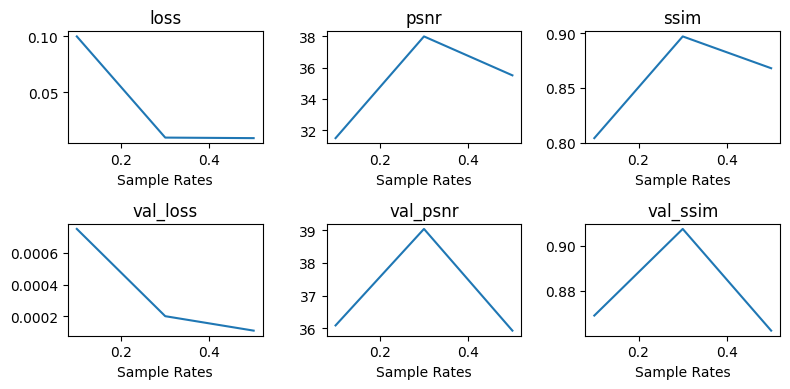

In [35]:
from collections import defaultdict

metric_dict = defaultdict(list)
for history in histories:        
    for k,v in history.history.items():
        metric_dict[k].append(v)

n_metric = len(metric_dict)
fig, axs = plt.subplots(2,3, squeeze=False, figsize=(8,4))
axs = axs.flatten()
for i, (k,v) in enumerate(metric_dict.items()):
    axs[i].plot(sample_rates, v)
    axs[i].set_xlabel('Sample Rates')
#     axs[0, i].plot(sample_rates, v)
#     axs[0, i].set_xlabel('Sample Rates')
#     axs[0, i].set_ylabel(k)
    axs[i].set_title(k)
plt.tight_layout()
plt.show()

In [36]:

val_ds_imgs = iter(get_ds_scans('val', 2, n=n_val, ds_bsz=ds_bsz))
scan_imgs = [next(val_ds_imgs).numpy().squeeze() for i in range(3)]

from skimage.transform import iradon, radon
n_samples = 512
circle=False
theta = np.linspace(0., 180., n_samples, endpoint=False)

def apply_inverse_transform(sinogram, unnormalize=False):
    
    sinogram = sinogram.copy()
    if unnormalize:
        sinogram *= sdev
        sinogram += mean       
    recon = iradon(sinogram, theta=theta, filter_name='ramp', circle=circle)
    return recon
    
scan_recon_imgs_lst = [[apply_inverse_transform(img, unnormalize=True) for img in recon_imgs] for recon_imgs in recon_imgs_lst]

# clip
scan_imgs = [ np.clip(img,0,1) for img in scan_imgs]
scan_recon_imgs_lst = [[ np.clip(img,0,1) for img in scan_recon_imgs] for scan_recon_imgs in scan_recon_imgs_lst]

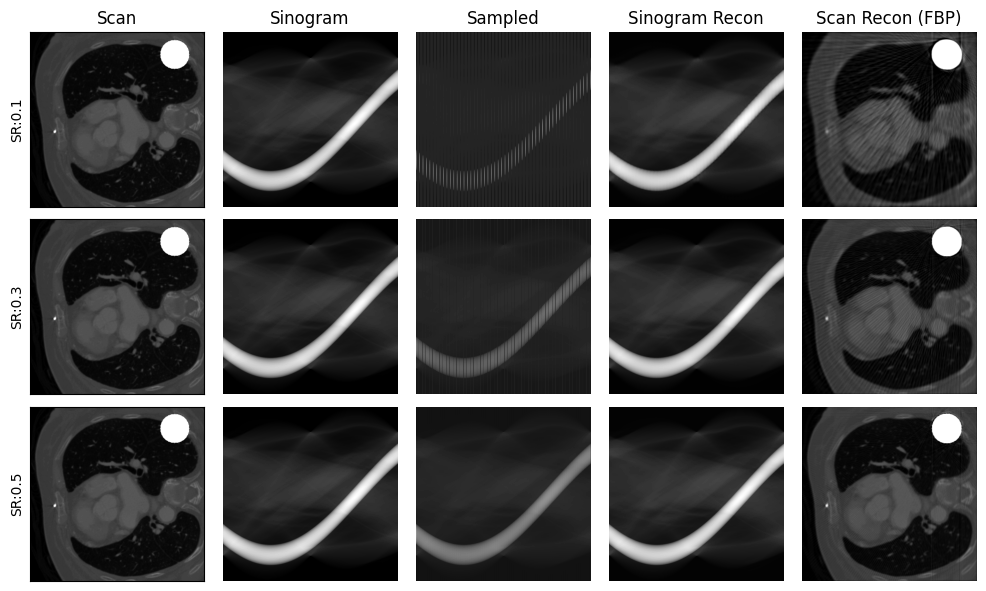

In [37]:
# before unet

pick = 0
scan_img = scan_imgs[pick]
n_sr = len(sample_rates)
fig, axs = plt.subplots(n_sr, 5, squeeze=False, figsize=(10, n_sr*2))
for i in range(n_sr):
    
    sr = sample_rates[i]

    input_img = input_imgs_lst[i][pick]
    sampled_img = sampled_imgs_lst[i][pick]
    recon_img = recon_imgs_lst[i][pick]
    scan_recon_img = scan_recon_imgs_lst[i][pick]
    
    axs[i, 0].imshow(scan_img, cmap='gray')
#     axs[i, 0].axis('off')
    axs[i, 0].set_yticklabels([])
    axs[i, 0].set_xticklabels([])
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].set_ylabel('SR:{}'.format(sr))

    axs[i, 1].imshow(input_img, cmap='gray')
    axs[i, 1].axis('off')


    axs[i, 2].imshow(sampled_img, cmap='gray')
    axs[i, 2].axis('off')

    
    axs[i, 3].imshow(recon_img, cmap='gray')
    axs[i, 3].axis('off')

    
    axs[i, 4].imshow(scan_recon_img, cmap='gray')
    axs[i, 4].axis('off')

    
    if i == 0:
        axs[i, 0].set_title('Scan')
        axs[i, 1].set_title('Sinogram')
        axs[i, 2].set_title('Sampled')
        axs[i, 3].set_title('Sinogram Recon')
        axs[i, 4].set_title('Scan Recon (FBP)')    

# plt.savefig(f'nplot-{n}_v{2}_ntrain-{n_train}_nval{n_val}_bsz-{ds_bsz}_epochs-{epochs}_sr-{sr}.png')
plt.tight_layout()
plt.show()


# Extra

In [ ]:
import matplotlib.pyplot as plt

metrics = histories[0].history.keys()

for metric in metrics:
    
    for his

for i, sr in enumerate(sample_rates):
    
    history = histories[i]
    
    input_imgs = input_imgs_lst[i]
    sampled_imgs = sampled_imgs_lst[i]
    recon_imgs = recon_imgs_lst[i]
    
plt.title("Loss (MSE)")
plt.plot(np.arange(epochs),hist.history.get('loss'), label="Train")
plt.plot(np.arange(epochs),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Sample Rate")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.savefig(f'training- nplot-{n}_v{2}_ntrain-{n_train}_nval{250}_bsz-{ds_bsz}_epochs-{epochs}.png')
plt.show()

plt.title("Learning Loss")
plt.plot(np.arange(epochs),hist.history.get('loss'), label="Train")
plt.plot(np.arange(epochs),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.savefig(f'training- nplot-{n}_v{2}_ntrain-{n_train}_nval{250}_bsz-{ds_bsz}_epochs-{epochs}.png')
plt.show()



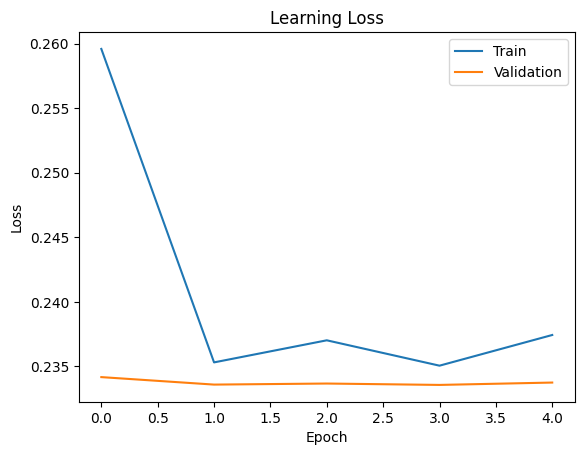

In [116]:
import matplotlib.pyplot as plt
plt.title("Loss (MSE)")
plt.plot(np.arange(epochs),hist.history.get('loss'), label="Train")
plt.plot(np.arange(epochs),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.savefig(f'training- nplot-{n}_v{2}_ntrain-{n_train}_nval{250}_bsz-{ds_bsz}_epochs-{epochs}.png')
plt.show()

plt.title("Learning Loss")
plt.plot(np.arange(epochs),hist.history.get('loss'), label="Train")
plt.plot(np.arange(epochs),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.savefig(f'training- nplot-{n}_v{2}_ntrain-{n_train}_nval{250}_bsz-{ds_bsz}_epochs-{epochs}.png')
plt.show()



In [47]:
# data without metrics
plot_ds = iter(val_ds)
val_ds_imgs = iter(get_ds_scans('val', 2, n=n_val, ds_bsz=ds_bsz))

n = 1
data = [next(plot_ds)[0] for i in range(n)]

subModel = Model(inputs=unet.input,
                  outputs=unet.get_layer(index=1).output)

input_imgs = [d.numpy().squeeze() for d in data]
sampled_imgs = [subModel.predict(d).squeeze() for d in data]
recon_imgs = [unet(d).numpy().squeeze() for d in data]



scan_imgs = [next(val_ds_imgs).numpy().squeeze() for i in range(n)]


1/1 [==============================] - 3s 3s/step


In [ ]:
val_ds_imgs = iter(get_ds_scans('val', 2, n=n_val, ds_bsz=ds_bsz))
scan_imgs = [next(val_ds_imgs).numpy().squeeze() for i in range(n)]

from skimage.transform import iradon, radon
n_samples = 512
circle=False
theta = np.linspace(0., 180., n_samples, endpoint=False)

def apply_inverse_transform(sinogram, unnormalize=False):
    
    sinogram = sinogram.copy()
    if unnormalize:
        sinogram *= sdev
        sinogram += mean       
    recon = iradon(sinogram, theta=theta, filter_name='ramp', circle=circle)
    return recon
    
scan_recon_imgs = [apply_inverse_transform(img, unnormalize=True) for img in recon_imgs]

# clip
scan_imgs = [ np.clip(img,0,1) for img in scan_imgs]
scan_recon_imgs = [ np.clip(img,0,1) for img in scan_recon_imgs]

In [48]:
from skimage.transform import iradon, radon
n_samples = 512
circle=False
theta = np.linspace(0., 180., n_samples, endpoint=False)

def apply_inverse_transform(sinogram, unnormalize=False):
    
    sinogram = sinogram.copy()
    if unnormalize:
        sinogram *= sdev
        sinogram += mean       
    recon = iradon(sinogram, theta=theta, filter_name='ramp', circle=circle)
    return recon
    
scan_recon_imgs = [apply_inverse_transform(img, unnormalize=True) for img in recon_imgs]

# clip
scan_imgs = [ np.clip(img,0,1) for img in scan_imgs]
scan_recon_imgs = [ np.clip(img,0,1) for img in scan_recon_imgs]

In [37]:
print('inputs', input_imgs[0].min(), input_imgs[0].max())
print('recons', recon_imgs[0].min(), recon_imgs[0].max())
print('scans', scan_imgs[0].min(), scan_imgs[0].max())
print('scan recons', scan_recon_imgs[0].min(), scan_recon_imgs[0].max())

inputs -0.90011215 5.480015
recons -0.9618905 5.485602
scans 0.00024587783 5.16
scan recons -0.22760731 5.5104713


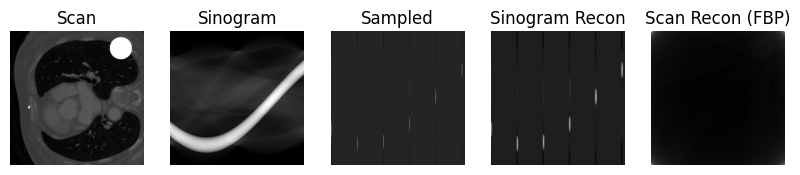

In [49]:
import matplotlib.pyplot as plt
# before unet
fig, axs = plt.subplots(n, 5, squeeze=False, figsize=(10, n*4))
for i in range(n):
    
    axs[i, 0].imshow(scan_imgs[i], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Scan')

    axs[i, 1].imshow(input_imgs[i], cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Sinogram')

    axs[i, 2].imshow(sampled_imgs[i], cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Sampled')
    
    axs[i, 3].imshow(recon_imgs[i], cmap='gray')
    axs[i, 3].axis('off')
    axs[i, 3].set_title('Sinogram Recon')
    
    axs[i, 4].imshow(scan_recon_imgs[i], cmap='gray')
    axs[i, 4].axis('off')
    axs[i, 4].set_title('Scan Recon (FBP)')
    
    
    

# plt.savefig(f'nplot-{n}_v{2}_ntrain-{n_train}_nval{n_val}_bsz-{ds_bsz}_epochs-{epochs}_sr-{sr}.png')
plt.show()


In [ ]:
unet()

# 1 point
# You need to define a subModel to access the output of an intermediate layer 
subModel = Model(inputs=custom_model.input,
                  outputs=custom_model.get_layer(index=0).output)

predictions = subModel.predict(x_train_illumination)

# old

In [ ]:
# unet = unet_model()


# unet.compile(optimizer=Adam(lr=0.001),  # pick an optimizer
#                      loss='mean_squared_error',  # pick a loss
#                      metrics=[psnr, ssim] # pick a metric to monitor 
#                      )  

# for ds_bsz in [1,2,3]:#,4,6,8]:
    
#     unet = unet_model()


#     unet.compile(optimizer=Adam(lr=0.001),  # pick an optimizer
#                          loss='mean_squared_error',  # pick a loss
#                          metrics=[psnr, ssim] # pick a metric to monitor 
#                          )  

#     start =  time.perf_counter()
#     epochs = 1
#     version = 1
#     n = 500
#     train_ds = get_ds('train', version, n=n, ds_bsz=ds_bsz)
#     val_ds = get_ds('val', version, n =n, ds_bsz=ds_bsz)
#     hist = unet.fit(
#                   train_ds, # data and targs
#                   epochs=epochs,
#                   validation_data= val_ds
#     )
#     end =  time.perf_counter()
#     print()
#     print('ds_bsz:{}  time: {:.2f}s'.format(ds_bsz, end-start))
#     print()

Experiment

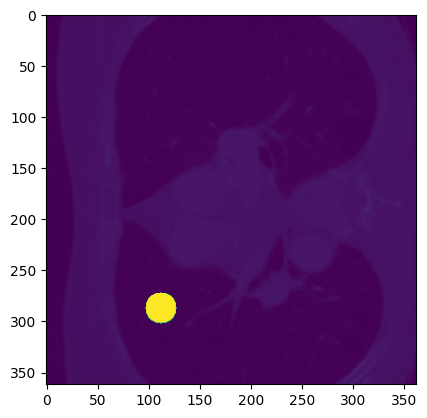

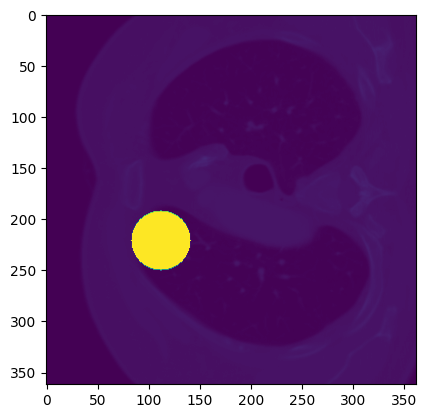

In [119]:
train_ds = get_ds_scans('train', version, n=2, ds_bsz=ds_bsz)
a = iter(train_ds)

plt.imshow(next(a)[0].numpy().squeeze())
plt.show()
plt.imshow(next(a)[0].numpy().squeeze())

In [109]:
a

StopIteration: 

effective sr: 0.01


gen img


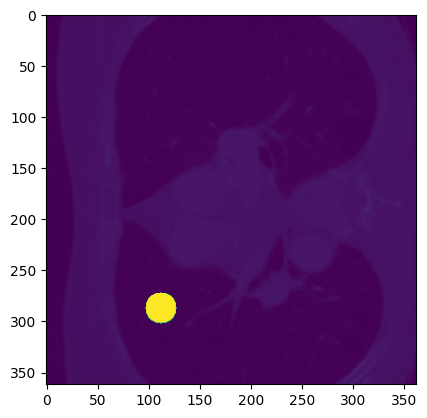

gen img


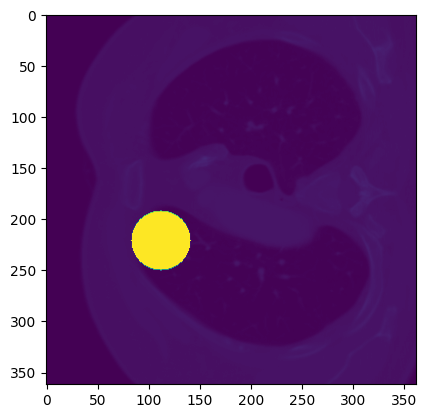


orig


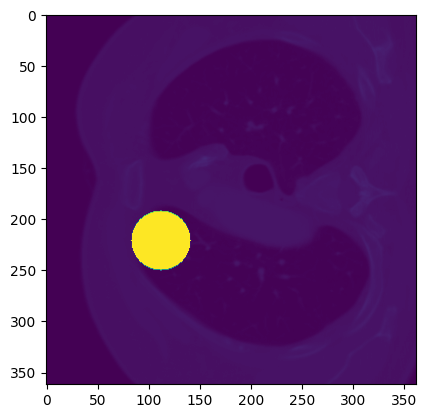

after


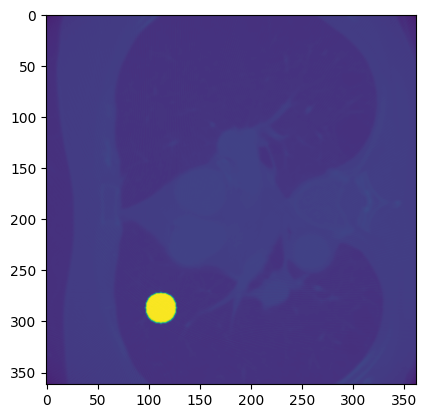

      1/Unknown - 7s 7s/step - loss: 0.4542 - ssim_sino: 0.3903 - psnr_sino: 6.7150 - ssim_scan: 0.3308 - psnr_scan: 14.4047
orig


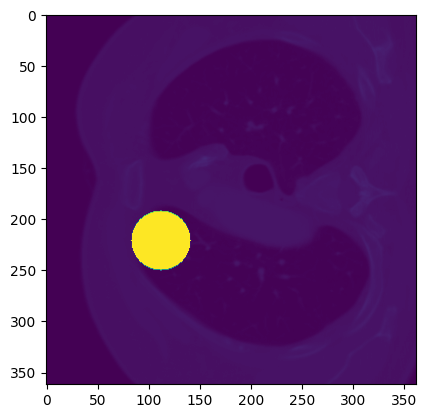

after


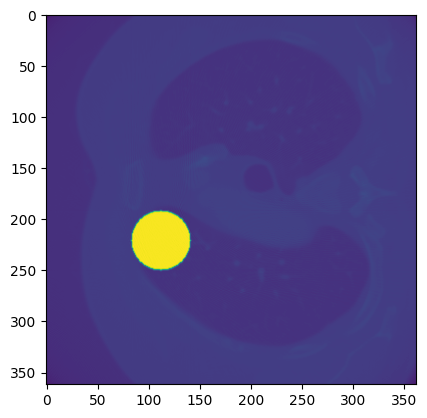

      2/Unknown - 9s 2s/step - loss: 1.1742 - ssim_sino: 0.4447 - psnr_sino: 9.2354 - ssim_scan: 0.3323 - psnr_scan: 15.9142gen img


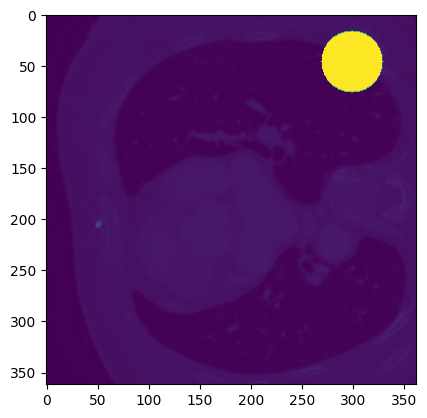

gen img


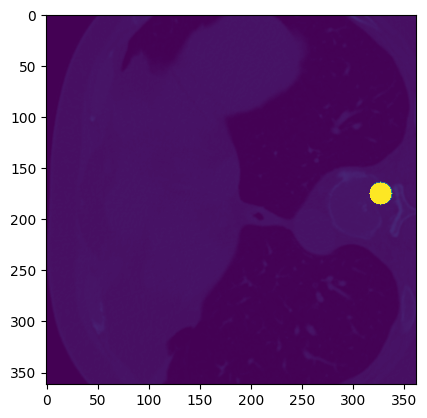


orig


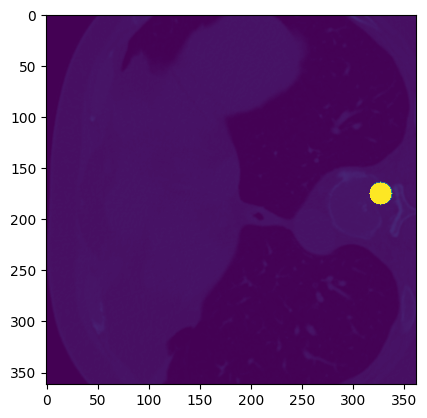

after


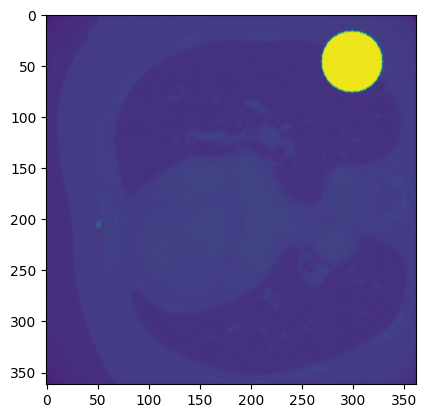


orig


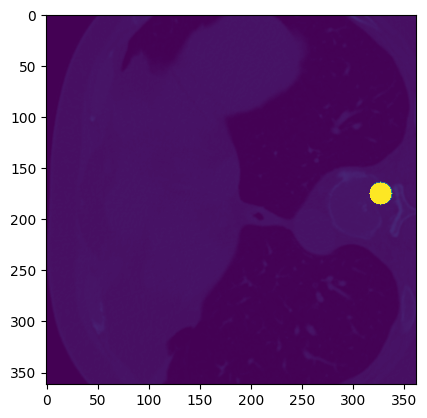

after


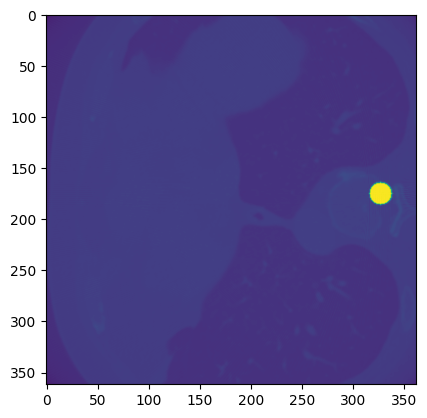

2/2 [==============================] - 12s 5s/step - loss: 1.1742 - ssim_sino: 0.4447 - psnr_sino: 9.2354 - ssim_scan: 0.3323 - psnr_scan: 15.9142 - val_loss: 1.1389 - val_ssim_sino: 0.6506 - val_psnr_sino: 14.2958 - val_ssim_scan: 0.3266 - val_psnr_scan: 15.6579


In [121]:



class ChangeSamplingRate(tf.keras.layers.Layer):
    def __init__(self, sr=0.1):
        super(ChangeSamplingRate, self).__init__()
        self.sr = sr
    
        indices = np.arange(0, 512, 1/self.sr).astype(int)
        print("effective sr: {:.2f}".format(len(indices)/512))  
        
    def call(self, x):
        sampled_sinogram = self.sample_sino(x)
        return sampled_sinogram

    def sample_sino(self, sinogram):

        # get number of columns in sinogram (equivalent to number of samples taken in scan)
        n_s = sinogram.shape[2] # 2 is the right dimension for BATCHED INPUT; otherwise 1

        # for given sampling rate, get columns that will not be sampled
        indices = np.arange(0, n_s, 1/self.sr).astype(int)
        theta_inds = np.arange(0, n_s)
        zero_inds = list(set(theta_inds) - set(indices)) # indices to be set to 0
        
        # set non-sampled columns to 0
        mask = [tf.one_hot(col_num*tf.ones((sinogram.shape[1], ), dtype=tf.int32), sinogram.shape[2])
                for col_num in zero_inds]
        mask = tf.reduce_sum(mask, axis=0)
        mask = tf.cast(tf.logical_not(tf.cast(mask, tf.bool)), tf.float32)
        mask = tf.expand_dims(mask, 0)
        mask = tf.expand_dims(mask, -1)
        result = sinogram * mask

        return result



### METRICS

def normalize_image_batch(images):
    
    min_values = tf.reduce_min(images, axis=[1, 2], keepdims=True)
    max_values = tf.reduce_max(images, axis=[1, 2], keepdims=True)

    return (images - min_values) / (max_values - min_values)


def apply_inverse_transform(sinogram, unnormalize=False):
    
    sinogram = sinogram.copy()
    if unnormalize:
        sinogram *= sdev
        sinogram += mean       
    recon = iradon(sinogram, theta=theta, filter_name='ramp', circle=circle)
    return recon

#### DATALOADER



class CT_net:
    
    

    def __init__(self):
        self.ct = 0
        self.stored_scans = {'train':[], 'val':[]}
        
        pass
    
    # These were calculated from our training set
    
    def fit(self):
        sr = 0.01

        # epochs = 1
        # version = 2
        # ds_bsz = 1
        # n_train = 1e3
        # n_val = 250
        # n_train = 1e4
        # n_val = 2500

        epochs = 1
        version = 2
        ds_bsz = 1
        self.n_train = 2
        self.n_val = 2


        unet = self.unet_model(sr=sr)

        unet.compile(optimizer=Adam(lr=0.001),  # pick an optimizer
                     loss='mean_squared_error',  # pick a loss
                     metrics= [self.ssim_sino, self.psnr_sino, self.ssim_scan, self.psnr_scan],
#                      {
                         
#                          ''
#                          'sino_recon': [psnr, ssim],
#                          'scan_recon': [psnr_scan, ssim_scan]
#                      },
                     run_eagerly=True
                    )
                                 
        train_ds = self.get_ds('train', version, n=n_train, ds_bsz=ds_bsz)
        val_ds = self.get_ds('val', version, n =n_val, ds_bsz=ds_bsz)
#         model_inputs {'a':train_ds, 'b':train_ds}
        hist = unet.fit(
                      train_ds, # data and targs
                      epochs=epochs,
                      validation_data= val_ds
        )

        # Old code

    def unet_model(self, input_shape=(512, 512, 1), base_filter=64, kernel_size=3,strides=(1, 1), sr=0.1):
        """
        sr : sampling_rate
        """

        inputs = Input(input_shape)

        #physical layer
        x = ChangeSamplingRate(sr)(inputs) # sr --> percentage sampled

        # down
        con1 = Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(x)
        con1 = Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(con1)
        x = MaxPooling2D(pool_size=(2, 2))(con1)
        con2 = Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(x)
        con2 = Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(con2)
        x = MaxPooling2D(pool_size=(2, 2))(con2)
        con3 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(x)
        con3 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(con3)
        x = MaxPooling2D(pool_size=(2, 2))(con3)
        con4 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(x)
        con4 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(con4)
        x = MaxPooling2D(pool_size=(2, 2))(con4)

        con5 =  Conv2D(base_filter*16, kernel_size, strides, padding='same', activation="relu")(x)
        con5 =  Conv2D(base_filter*16, kernel_size, strides, padding='same', activation="relu")(con5)


        # up
        up = Conv2DTranspose(base_filter*8, kernel_size, strides=(2,2), padding='same', activation='relu')(con5)
        merge1 = concatenate([up, con4], axis=-1)
        con6 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(merge1)
        con6 =  Conv2D(base_filter*8, kernel_size, strides, padding='same', activation="relu")(con6)
        up = Conv2DTranspose(base_filter*4, kernel_size, strides=(2,2), padding='same', activation='relu')(con6)
        merge2 = concatenate([up, con3], axis=-1)
        con7 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(merge2)
        con7 =  Conv2D(base_filter*4, kernel_size, strides, padding='same', activation="relu")(con7)
        up = Conv2DTranspose(base_filter*2, kernel_size, strides=(2,2), padding='same', activation='relu')(con7)
        merge3 = concatenate([up, con2], axis=-1)
        con8 =  Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(merge3)
        con8 =  Conv2D(base_filter*2, kernel_size, strides, padding='same', activation="relu")(con8)
        up = Conv2DTranspose(base_filter, kernel_size, strides=(2,2), padding='same', activation='relu')(con8)
        merge4 = concatenate([up, con1], axis=-1)
        con9 =  Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(merge4)
        con9 =  Conv2D(base_filter, kernel_size, strides, padding='same', activation="relu")(con9)
        out = Conv2D(1, kernel_size=(1, 1), strides=(1,1), padding='same')(con9)
    #     out = Conv2D(1, kernel_size=(1, 1), strides=(1,1), padding='same', activation="relu")(con9)
        
#         scan_input = self.img
#         return Model(inputs=inputs, outputs = [sino_recon, scan_recon])
        return Model(inputs=inputs, outputs=out)

    def get_ds(self, dset, version=2, n=1, ds_bsz = 1):
        
        mean=56.23
        variance=3902.5
        sdev = np.sqrt(variance)
        
        outer_class = self
        class generator:
            def __call__(self, index):
                img, sino, settings = load_sim_data(int(index), dset=dset, version=version)
#                 print("gen img")
#                 plt.imshow(img)
#                 plt.show()
                outer_class.scan = tf.convert_to_tensor(np.reshape(img, (1, 362, 362, 1)))
                outer_class.stored_scans[dset].append(img)
                if version == 2:

                    pass
                if version == 1:
                    sino = resize(sino, (512,512)) # tshould this be in transform...
                sino = sino[:,:,np.newaxis]

                # normalization
                sino -= mean
                sino  /= sdev

                yield sino, sino

        # get the indices for the files that we want to use
        file_inds = np.arange(1,n+1)

        # Create dataset from generator in order to deliver tuple as output 
        # (which is necessary to have data and target as the same image)
        cycle_length = 1
        block_length = 1
        ds = tf.data.Dataset.from_tensor_slices(file_inds)
        ds = ds.interleave(lambda file_ind: tf.data.Dataset.from_generator(
                generator(), 
                output_signature=(
                    tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
                    tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32)
                ),
                args=(file_ind,)),
               cycle_length, block_length)
        ds = ds.batch(ds_bsz)

        return ds
    
    def ssim_scan(self, output, groundtruth):
        # apply iradon 
        scan_recon = apply_inverse_transform(output.numpy().squeeze())
        # convert back to tf format
        scan_recon = np.reshape(scan_recon, (1, 362, 362, 1))
        scan_recon = tf.convert_to_tensor(scan_recon)
        
        self.scan_recon = normalize_image_batch(scan_recon)
        output = self.scan_recon
        # get input image
        groundtruth = self.stored_scans, #self.scan   
        groundtruth = normalize_image_batch(groundtruth)
        print()
        print('orig')
        plt.imshow(groundtruth.numpy().squeeze())
        plt.show()
        print('after')
        plt.imshow(output.numpy().squeeze())
        
        plt.show()
#         print('ssim scan')     
        return tf.image.ssim(output, groundtruth, max_val=1.0, filter_size=4,
                              filter_sigma=1.5, k1=0.01, k2=0.03)

    def psnr_scan(self, output, groundtruth):
#         print('psnr scan')
        groundtruth = self.scan
#         output = normalize_image_batch(output)
        output = self.scan_recon
        groundtruth = normalize_image_batch(groundtruth)   
        return tf.image.psnr(output, groundtruth, max_val=1.0)
    
    def ssim_sino(self, output, groundtruth):
#         print('ssim sino')
        output = normalize_image_batch(output)
        groundtruth = normalize_image_batch(groundtruth)
        return tf.image.ssim(output, groundtruth, max_val=1.0, filter_size=4,
                              filter_sigma=1.5, k1=0.01, k2=0.03)

    def psnr_sino(self, output, groundtruth):
#         print('psnr sino')
        output = normalize_image_batch(output)
        groundtruth = normalize_image_batch(groundtruth)   
        return tf.image.psnr(output, groundtruth, max_val=1.0)
    
model = CT_net()
model.fit()

In [93]:
362*362

131044

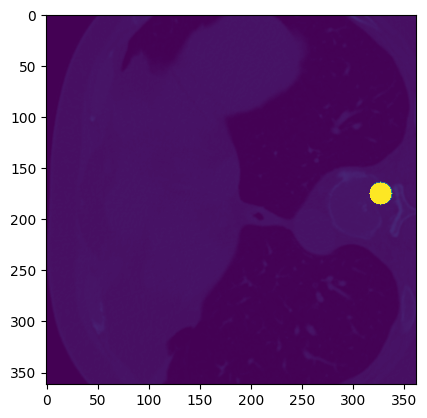

In [70]:
plt.imshow(model.img)

In [80]:
tf.executing_eagerly()

True

In [19]:
def get_ds_scans(dset, version=2, n=1, ds_bsz = 1):
    
    class generator:
        def __call__(self, index):
            img, sino, settings = load_sim_data(int(index), dset=dset, version=version)

            img = img[:,:,np.newaxis]

            yield img
    # get the indices for the files that we want to use
    file_inds = np.arange(1,n+1)

    # Create dataset from generator in order to deliver tuple as output 
    # (which is necessary to have data and target as the same image)
    cycle_length = 1
    block_length = 2
    ds = tf.data.Dataset.from_tensor_slices(file_inds)
    ds = ds.interleave(lambda file_ind: tf.data.Dataset.from_generator(
            generator(), 
            output_signature=tf.TensorSpec(shape=(362, 362, 1), dtype=tf.float32),
            args=(file_ind,)),
           cycle_length, block_length)
    ds = ds.batch(ds_bsz)
    
    return ds
# val_ds_imgs = iter(get_ds_imgs('val', 2, n=n_val, ds_bsz=ds_bsz))
# a = next(val_ds_imgs) 

effective sr: 0.01


2/2 [==============================] - 13s 3s/step - loss: 1.1753 - psnr: 7.4908 - ssim: 0.3870 - val_loss: 1.1423 - val_psnr: 14.2683 - val_ssim: 0.6494
